In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import requests
import math 
from math import floor
from scipy.stats.mstats import winsorize
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from keras.models import Sequential 
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## Importo il dataset con i prezzi

In [2]:
df = pd.read_csv("file2.csv")

In [3]:
df.head()

,Date,ETH,BTC,XRP,LTC,XLM,Palladium,Gold,HSI,N225,SP500,NVIDIA,AMD
0,2016-01-02,-0.011498,-0.002049,0.018472,-0.002849,-0.004005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2016-01-03,0.037115,-0.007913,-0.007914,-0.005714,0.001723,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2016-01-04,-0.017929,0.007163,-0.009806,0.005747,0.002294,-0.023911,0.008379,-0.015704,-0.015203,-0.012430,-0.017900,-0.034843
3,2016-01-05,-0.004509,-0.002609,0.014434,-0.008571,-0.015446,-0.015527,0.002976,-0.006489,-0.004172,0.001294,0.016064,-0.007220
4,2016-01-06,0.000720,-0.006598,-0.006784,-0.005764,-0.028472,-0.023911,0.008379,-0.009812,-0.009942,-0.012430,-0.036179,-0.044248


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1826 non-null   object 
 1   ETH        1826 non-null   float64
 2   BTC        1826 non-null   float64
 3   XRP        1826 non-null   float64
 4   LTC        1826 non-null   float64
 5   XLM        1826 non-null   float64
 6   Palladium  1826 non-null   float64
 7   Gold       1826 non-null   float64
 8   HSI        1826 non-null   float64
 9   N225       1826 non-null   float64
 10  SP500      1826 non-null   float64
 11  NVIDIA     1826 non-null   float64
 12  AMD        1826 non-null   float64
dtypes: float64(12), object(1)
memory usage: 185.6+ KB


In [5]:
df['Date'] = pd.to_datetime(df['Date'],format = "%Y-%m-%d")

In [6]:
df.set_index('Date', inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2016-01-02 to 2020-12-31
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ETH        1826 non-null   float64
 1   BTC        1826 non-null   float64
 2   XRP        1826 non-null   float64
 3   LTC        1826 non-null   float64
 4   XLM        1826 non-null   float64
 5   Palladium  1826 non-null   float64
 6   Gold       1826 non-null   float64
 7   HSI        1826 non-null   float64
 8   N225       1826 non-null   float64
 9   SP500      1826 non-null   float64
 10  NVIDIA     1826 non-null   float64
 11  AMD        1826 non-null   float64
dtypes: float64(12)
memory usage: 185.5 KB


In [8]:
df.head(3)

,ETH,BTC,XRP,LTC,XLM,Palladium,Gold,HSI,N225,SP500,NVIDIA,AMD
Date,,,,,,,,,,,,
2016-01-02,-0.011498,-0.002049,0.018472,-0.002849,-0.004005,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000
2016-01-03,0.037115,-0.007913,-0.007914,-0.005714,0.001723,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000
2016-01-04,-0.017929,0.007163,-0.009806,0.005747,0.002294,-0.023911,0.008379,-0.015704,-0.015203,-0.01243,-0.0179,-0.034843


## Model

scalare il dataset e metterlo in forma di array

In [9]:
nrows = df.shape[0]
np_data = np.reshape(np.array(df), (nrows, -1))

In [10]:
# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler(feature_range=(-1,1))
np_data = scaler.fit_transform(np_data)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler(feature_range=(-1,1))
df_Close = pd.DataFrame(df['BTC'])
np_BTC_scaled = scaler_pred.fit_transform(df_Close)

In [11]:
type(np_data)

numpy.ndarray

In [12]:
np_data.shape

(1826, 12)

In [13]:
np_data[0]

array([-0.0879007 ,  0.11605331,  0.44547235,  0.09115775,  0.06846474,
        0.10722734,  0.15576874,  0.18592641,  0.18049311,  0.17817261,
        0.16271744,  0.12761727])

In [14]:
type(np_data)

numpy.ndarray

la variabile target viene scelta, posso scegliere qualsiasi variabile

In [15]:
index = df.columns.get_loc("BTC")
index

1

In [16]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 1 # = number of neurons in the first layer of the neural network

# Prediction Index

index_Close = index

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data.shape[0] * 0.9)

# Create the training and test data
train_data = np_data[0:train_data_len, :]
test_data = np_data[train_data_len - sequence_length:, :]

In [17]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
              break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end,index_Close]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)
n_past = 1
n_future = 1


n_past e n_future ti dicono rispettitivamente quanti giorni indietro saranno presi in considerazione per la predizione, e quanti giorni avanti sarà la variabile target.

In [18]:
# Generate training data and test data
x_train, y_train = split_series(train_data,n_past, n_future)
x_test, y_test = split_series(test_data,n_past, n_future)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][n_past-1][index_Close])
print(y_train[0])

(1643, 1, 12) (1643, 1)
(182, 1, 12) (182, 1)
0.003181972086130136
[0.00318197]


creo il dataset di train e di test e faccio un check per vedere se la seconda finestra di dati contiene il risultato della prima

In [19]:
x_train[0:6]

array([[[-0.0879007 ,  0.11605331,  0.44547235,  0.09115775,
          0.06846474,  0.10722734,  0.15576874,  0.18592641,
          0.18049311,  0.17817261,  0.16271744,  0.12761727]],

       [[ 0.56774251,  0.00318197,  0.03411541,  0.04925856,
          0.13738347,  0.10722734,  0.15576874,  0.18592641,
          0.18049311,  0.17817261,  0.16271744,  0.12761727]],

       [[-0.1746384 ,  0.29335371,  0.00463042,  0.21685942,
          0.14424717, -1.        ,  1.        , -1.        ,
         -1.        , -1.        , -0.41257073, -0.76033222]],

       [[ 0.00635248,  0.10527442,  0.38252819,  0.00747841,
         -0.06920667, -0.61179449,  0.45562947, -0.30412299,
         -0.1434746 ,  0.30083228,  0.67899266, -0.05638382]],

       [[ 0.07687883,  0.02850364,  0.05174251,  0.04853614,
         -0.2259369 , -1.        ,  1.        , -0.55506271,
         -0.59152442, -1.        , -1.        , -1.        ]],

       [[-0.05843145,  1.        ,  0.25099048,  0.76860384,
         

In [20]:
#ti da come y i 5 dati futuri di BTC
y_train[0:6]

array([[ 0.00318197],
       [ 0.29335371],
       [ 0.10527442],
       [ 0.02850364],
       [ 1.        ],
       [-0.04704225]])

In [21]:
x_train.shape, y_train.shape

((1643, 1, 12), (1643, 1))

In [22]:
x_test.shape, y_test.shape

((182, 1, 12), (182, 1))

In [23]:
len(x_train)

1643

In [24]:
df.head(3)

,ETH,BTC,XRP,LTC,XLM,Palladium,Gold,HSI,N225,SP500,NVIDIA,AMD
Date,,,,,,,,,,,,
2016-01-02,-0.011498,-0.002049,0.018472,-0.002849,-0.004005,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000
2016-01-03,0.037115,-0.007913,-0.007914,-0.005714,0.001723,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000
2016-01-04,-0.017929,0.007163,-0.009806,0.005747,0.002294,-0.023911,0.008379,-0.015704,-0.015203,-0.01243,-0.0179,-0.034843


In [25]:
list1 = []
for i in range(y_train.shape[0]):
      list1.append(y_train[i][-1])
#print(i)        

In [26]:
list2 = []
for i in range(len(y_test)):
      list2.append(y_test[i][-1])

In [27]:
y_train = np.array(list1)

In [28]:
y_train.shape[0]

1643

In [29]:
y_train.shape

(1643,)

In [30]:
y_test = np.array(list2)

In [31]:
y_test.shape

(182,)

In [32]:
#x_train[0:6]

In [33]:
#y_train[0:6]

In [34]:
x_train[1]

array([[0.56774251, 0.00318197, 0.03411541, 0.04925856, 0.13738347,
        0.10722734, 0.15576874, 0.18592641, 0.18049311, 0.17817261,
        0.16271744, 0.12761727]])

In [35]:
y_train[1]

0.29335371360118434

## LSTM

creazione della rete, settaggio dei vari layer e dei parametri

In [36]:
n_neurons = x_train.shape[1] * x_train.shape[2]

In [37]:
n_neurons

12

In [38]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import Adam


def createModel(l1Nodes, l2Nodes, d1Nodes, d2Nodes, inputShape):
    # input layer
    lstm1 = LSTM(l1Nodes, input_shape=inputShape, return_sequences=True)
    lstm2 = LSTM(l2Nodes, return_sequences=True)
    flatten = Flatten()
    dense1 = Dense(d1Nodes)
    dense2 = Dense(d2Nodes)

    # output layer
#     outL = Dense(1, activation='relu')
    outL = Dense(1)
    # combine the layers
    layers = [lstm1, lstm2, flatten,  dense1, dense2, outL]
    # create the model
    model = Sequential(layers)
    opt = Adam(learning_rate=0.005)
    model.compile(optimizer=opt, loss='mse')
    return model

In [39]:
model = createModel(12,12, 8, 4, (x_train.shape[1], x_train.shape[2]))
model.fit(x_train, y_train, batch_size=12, epochs=1, validation_data = (x_test, y_test))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 1643 samples, validate on 182 samples
Epoch 1/1
1643/1643 [==============================] - 1s 569us/step - loss: 0.2818 - val_loss: 0.1955


#### predizione del modello

In [40]:
from sklearn.metrics import mean_squared_error as mse

In [41]:
y_pred_train = model.predict(x_train)
mse(y_train, y_pred_train)

0.2757454819667154

In [42]:
y_pred = model.predict(x_test)
mse(y_test, y_pred)

0.19552693873062849

In [43]:
y_pred.shape

(182, 1)

In [44]:
y_test.shape

(182,)

In [45]:
df["BTC"].iloc[train_data_len - sequence_length:]

Date
2020-07-02   -0.011369
2020-07-03   -0.003958
2020-07-04    0.004973
2020-07-05   -0.006411
2020-07-06    0.033230
                ...   
2020-12-27   -0.006232
2020-12-28    0.030927
2020-12-29    0.010250
2020-12-30    0.043877
2020-12-31    0.005574
Name: BTC, Length: 183, dtype: float64

In [46]:
y_test

array([ 0.07931396,  0.25120719,  0.03209626,  0.79508364, -0.09740712,
        0.52172385, -0.15145462,  0.15723594,  0.07571516,  0.23079199,
        0.08725211,  0.15466047,  0.05060764,  0.0285933 ,  0.19587518,
        0.17158282,  0.21176996,  0.11025551,  0.59793229,  0.46441688,
        0.26806241,  0.0667412 ,  0.43848292,  0.60909088,  1.        ,
        0.01881238,  0.48645588,  0.17411552,  0.52317677,  0.89679285,
       -1.        ,  0.4911034 ,  0.08624946,  1.        ,  0.20915338,
       -0.13583433,  0.40862814,  0.02726121,  0.48909559, -0.60216919,
        0.4496698 ,  0.48646056,  0.13055267,  0.31385223,  0.19945189,
        0.74070309, -0.25785057, -0.2184159 ,  0.35206926, -0.30773396,
        0.3038259 ,  0.12751681,  0.33658258, -0.51219008,  0.36245817,
       -0.1208747 ,  0.52791316,  0.09608013,  0.49778836,  0.10505613,
        0.63278346, -0.73921567, -1.        ,  0.65616854, -0.47115009,
        0.36515839,  0.32251505, -0.28633832,  0.3660408 ,  0.38

In [47]:
y_pred

array([[0.14314863],
       [0.16216065],
       [0.13823642],
       [0.15672284],
       [0.13805752],
       [0.13672087],
       [0.09572974],
       [0.16121985],
       [0.13294052],
       [0.13964142],
       [0.14589897],
       [0.1824924 ],
       [0.11899106],
       [0.158788  ],
       [0.14173695],
       [0.1345488 ],
       [0.14327863],
       [0.14671092],
       [0.1445575 ],
       [0.13291524],
       [0.11412007],
       [0.16767053],
       [0.14050066],
       [0.10405558],
       [0.15591203],
       [0.11421356],
       [0.13180748],
       [0.10781376],
       [0.12117289],
       [0.10037653],
       [0.10385507],
       [0.15362047],
       [0.13786572],
       [0.15461896],
       [0.12953939],
       [0.13818777],
       [0.188939  ],
       [0.14199033],
       [0.14912885],
       [0.1342986 ],
       [0.22556913],
       [0.144728  ],
       [0.1326149 ],
       [0.15714522],
       [0.13651876],
       [0.12938981],
       [0.12034081],
       [0.151

In [48]:
def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white') 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    plt.plot(predicted_data, label='Prediction',color='red') 
    plt.legend() 
    plt.show()

In [49]:
#plot_results(y_pred_train,y_train)

In [50]:
y_pred_noscaled = scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

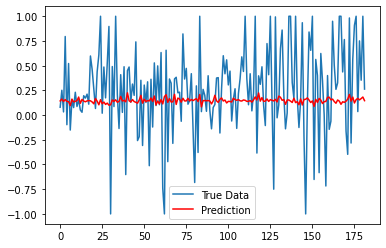

In [51]:
plot_results(y_pred,y_test)

In [52]:
#y_test_unscaled

In [53]:
#y_pred_noscaled

In [54]:
#plot_results(y_pred,y_test)

#### grafico dei risultati del test set dopo avere riportato i dati al loro valore originale(non scalati)

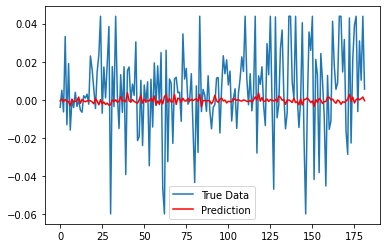

In [55]:
plot_results(y_pred_noscaled,y_test_unscaled)

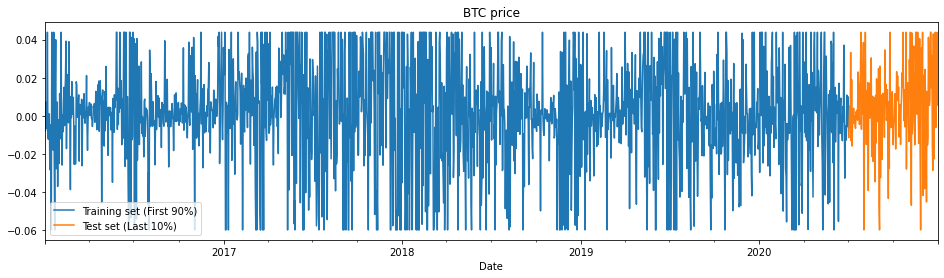

In [56]:
df["BTC"].iloc[0:train_data_len].plot(figsize=(16,4),legend=True)
df["BTC"].iloc[train_data_len - n_past:].plot(figsize=(16,4),legend=True) # 10% is used for thraining data which is approx 2017 data
plt.legend(['Training set (First 90%)','Test set (Last 10%)'])
plt.title('BTC price')
plt.show()

In [57]:
df.head()

,ETH,BTC,XRP,LTC,XLM,Palladium,Gold,HSI,N225,SP500,NVIDIA,AMD
Date,,,,,,,,,,,,
2016-01-02,-0.011498,-0.002049,0.018472,-0.002849,-0.004005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-03,0.037115,-0.007913,-0.007914,-0.005714,0.001723,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-04,-0.017929,0.007163,-0.009806,0.005747,0.002294,-0.023911,0.008379,-0.015704,-0.015203,-0.012430,-0.017900,-0.034843
2016-01-05,-0.004509,-0.002609,0.014434,-0.008571,-0.015446,-0.015527,0.002976,-0.006489,-0.004172,0.001294,0.016064,-0.007220
2016-01-06,0.000720,-0.006598,-0.006784,-0.005764,-0.028472,-0.023911,0.008379,-0.009812,-0.009942,-0.012430,-0.036179,-0.044248


In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 12)             1200      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 12)             1200      
_________________________________________________________________
flatten_1 (Flatten)          (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 2,545
Trainable params: 2,545
Non-trainable params: 0
____________________________________________________

In [59]:
#!pip install shap==0.40.0

Importo shap dopo averlo installato

In [60]:
import shap

In [61]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [62]:
x_test[1]

array([[-0.16801409,  0.07931396,  0.07763273,  0.03413352, -0.0868643 ,
         0.10722734,  0.15576874,  0.93413984,  0.74331886,  0.17817261,
         0.16271744,  0.12761727]])

In [63]:
x_test[1:2]

array([[[-0.16801409,  0.07931396,  0.07763273,  0.03413352,
         -0.0868643 ,  0.10722734,  0.15576874,  0.93413984,
          0.74331886,  0.17817261,  0.16271744,  0.12761727]]])

In [64]:
# Use the training data for deep explainer => can use fewer instances
explainer = shap.DeepExplainer(model, x_train)
# explain the the testing instances (can use fewer instanaces)
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(x_test)
# init the JS visualization code
shap.initjs()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


keras is no longer supported, please use tf.keras instead.


In [102]:
#shap.plots.bar(explainer(background))

In [99]:
#background = shap.maskers.Independent(x_train)

Utilizzo il DeepExplainer sul tutto il training set e calcolo gli shapley values sul test set

In [65]:
shap_values

[array([[[ 2.06634118e-03, -1.28734534e-03,  7.24545452e-05, ...,
          -3.12967894e-03, -1.76106356e-03, -1.26979472e-03]],
 
        [[ 2.50092594e-03, -5.95929432e-04,  9.23552621e-04, ...,
          -7.77522484e-04, -4.07705307e-04, -1.89313507e-03]],
 
        [[-7.72240602e-04,  8.32348497e-04, -1.25277825e-03, ...,
          -8.18271167e-04, -4.31950982e-04, -2.00553575e-03]],
 
        ...,
 
        [[-2.69270580e-03,  5.94560156e-03,  1.03343825e-02, ...,
          -8.25582225e-04,  1.82185214e-03, -1.13939379e-03]],
 
        [[ 7.84814287e-04,  1.95654179e-03,  8.82579281e-03, ...,
          -8.16961909e-04, -1.13234019e-03,  1.90312444e-03]],
 
        [[-3.91677376e-04,  9.34545411e-03,  4.89456859e-03, ...,
          -8.23619736e-04, -3.98973843e-03, -6.39449236e-03]]])]

L' expected value sarebbe il valore base, ovvero il modello senza feature(average dei dati target)

In [66]:
explainer.expected_value

array([0.14903489], dtype=float32)

In [67]:
y_test[1:2]

array([0.25120719])

In [68]:
y_pred[1:2]

array([[0.16216065]], dtype=float32)

In [69]:
len(shap_values)

1

#### check sulla dimensione dei dati e degli shapley values, devono matchare

In [70]:
x_test.shape

(182, 1, 12)

In [71]:
shap_values[0].shape

(182, 1, 12)

In [72]:
shap_values[0][0].shape

(1, 12)

In [73]:
features = list(df.columns)

In [74]:
features

['ETH',
 'BTC',
 'XRP',
 'LTC',
 'XLM',
 'Palladium',
 'Gold',
 'HSI',
 'N225',
 'SP500',
 'NVIDIA',
 'AMD']

In [75]:
i=0
j=0

In [76]:
#shap_values[0][i][j]

In [77]:
#x_test[i][j].shape

In [78]:
explainer.expected_value[0], shap_values[0][i][j]

(0.14903489,
 array([ 2.06634118e-03, -1.28734534e-03,  7.24545452e-05,  1.62701749e-03,
        -1.05054220e-03,  6.92768342e-05, -3.84005141e-03,  8.45999432e-04,
         1.77112810e-03, -3.12967894e-03, -1.76106356e-03, -1.26979472e-03]))

In [79]:
x_test_df = pd.DataFrame(data=x_test[i][j].reshape(1,12), columns = features)

In [80]:
x_test_df

,ETH,BTC,XRP,LTC,XLM,Palladium,Gold,HSI,N225,SP500,NVIDIA,AMD
0,-0.033207,-0.063334,0.181106,0.059178,0.102243,0.032876,0.72749,1.0,0.265545,1.0,0.44009,0.011296


In [81]:
shap_values[0]

array([[[ 2.06634118e-03, -1.28734534e-03,  7.24545452e-05, ...,
         -3.12967894e-03, -1.76106356e-03, -1.26979472e-03]],

       [[ 2.50092594e-03, -5.95929432e-04,  9.23552621e-04, ...,
         -7.77522484e-04, -4.07705307e-04, -1.89313507e-03]],

       [[-7.72240602e-04,  8.32348497e-04, -1.25277825e-03, ...,
         -8.18271167e-04, -4.31950982e-04, -2.00553575e-03]],

       ...,

       [[-2.69270580e-03,  5.94560156e-03,  1.03343825e-02, ...,
         -8.25582225e-04,  1.82185214e-03, -1.13939379e-03]],

       [[ 7.84814287e-04,  1.95654179e-03,  8.82579281e-03, ...,
         -8.16961909e-04, -1.13234019e-03,  1.90312444e-03]],

       [[-3.91677376e-04,  9.34545411e-03,  4.89456859e-03, ...,
         -8.23619736e-04, -3.98973843e-03, -6.39449236e-03]]])

#### Grafico dei contributi per la prima osservazione nel test set

Force plot gives us the explainability of a single model prediction. In this plot, we can see how features contributed to the model’s prediction for a specific observation. It is very convenient to use for error analysis or a deep understanding of a particular case.

In [82]:
# shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)
shap.initjs()
i = 0
j = 0
x_test_df = pd.DataFrame(data=x_test[i][j].reshape(1,12), columns = features)
shap.force_plot(explainer.expected_value[0], shap_values[0][i][j], x_test_df, matplotlib=False,show=True, figsize=(23, 4), text_rotation=0)

The model predict_proba value: 0.79
The base value: this is the value that would be predicted if we didn’t know any features for the current instance. The base value is the average of the model output over the training dataset (explainer.expected_value in the code). In this example base value = 0.5749
The numbers on the plot arrows are the value of the feature for this instance. Elapsed Time (sec)=5 and Packets = 1
Red represents features that pushed the model score higher, and blue representing features that pushed the score lower.
The bigger the arrow, the bigger the impact of the feature on the output. The amount of decrease or increase in the impact can be seen on the x-axis.
Elapsed Time of 5 seconds increases the property that the class is allow, Packets of 6.546 reduce the property value.

In [83]:
from shap.plots import _waterfall

The waterfall plot is another local analysis plot of a single instance prediction. Let’s take instance number 8 as an example:

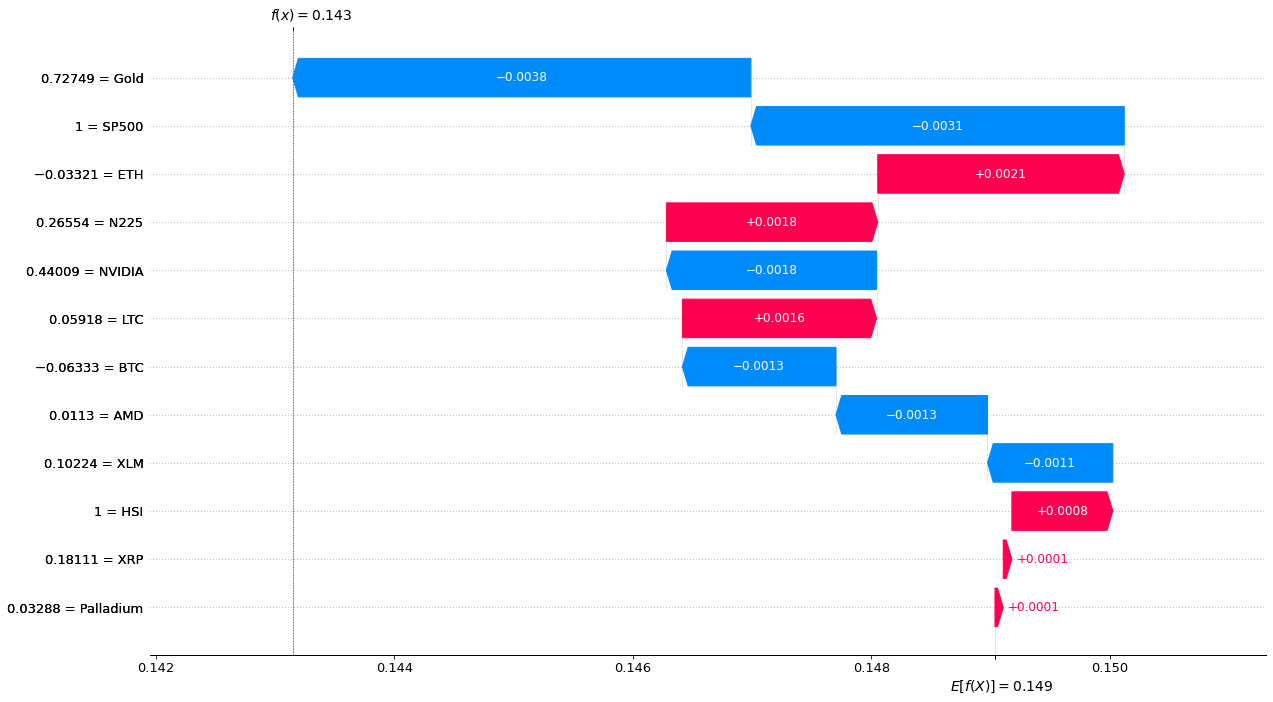

In [84]:
import matplotlib.pyplot as pl
import matplotlib
_waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0][0],features= x_test_df.iloc[0],max_display=12)


f(x) is the model predict_proba value: 0.79.
E[f(x)] is the base value = 0.5749.
On the left are the features value and on the arrows the feature contribution to the prediction.
Each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction [2].

In [85]:
#devo guardare y_pred e non y_test
#y_pred

#### check sulla somma degli shapley values della prima osservazione al valore base che deve essere uguale alla predizione della prima osservazione

In [86]:

pred_i = model.predict(x_test)
sum_shap_i = shap_values[0][0].sum() + explainer.expected_value[0]

pred_i[0], sum_shap_i

(array([0.14314863], dtype=float32), 0.14314862896500088)

In [87]:
shap.__version__

'0.40.0'

#### modifico la dimensione dei dati e degli shapley values in maniera tale da analizzarli globalmente

In [88]:
shap_values_2D = shap_values[0].reshape(-1,12)
x_test_2D = x_test.reshape(-1,12)


shap_values_2D.shape, x_test_2D.shape

((182, 12), (182, 12))

In [89]:
shap_values_2D

array([[ 2.06634118e-03, -1.28734534e-03,  7.24545452e-05, ...,
        -3.12967894e-03, -1.76106356e-03, -1.26979472e-03],
       [ 2.50092594e-03, -5.95929432e-04,  9.23552621e-04, ...,
        -7.77522484e-04, -4.07705307e-04, -1.89313507e-03],
       [-7.72240602e-04,  8.32348497e-04, -1.25277825e-03, ...,
        -8.18271167e-04, -4.31950982e-04, -2.00553575e-03],
       ...,
       [-2.69270580e-03,  5.94560156e-03,  1.03343825e-02, ...,
        -8.25582225e-04,  1.82185214e-03, -1.13939379e-03],
       [ 7.84814287e-04,  1.95654179e-03,  8.82579281e-03, ...,
        -8.16961909e-04, -1.13234019e-03,  1.90312444e-03],
       [-3.91677376e-04,  9.34545411e-03,  4.89456859e-03, ...,
        -8.23619736e-04, -3.98973843e-03, -6.39449236e-03]])

In [90]:
x_test_2d = pd.DataFrame(data=x_test_2D, columns = features)

In [91]:
x_test

array([[[-0.03320661, -0.0633344 ,  0.18110612, ...,  1.        ,
          0.44009009,  0.01129555]],

       [[-0.16801409,  0.07931396,  0.07763273, ...,  0.17817261,
          0.16271744,  0.12761727]],

       [[ 0.28737896,  0.25120719,  0.30319779, ...,  0.17817261,
          0.16271744,  0.12761727]],

       ...,

       [[ 1.        ,  0.75074879, -1.        , ...,  0.17817261,
         -0.06915942,  0.06932654]],

       [[ 0.08785122,  0.35278461, -1.        , ...,  0.17817261,
          0.27046738, -0.14502976]],

       [[ 0.43775838,  1.        , -0.48694802, ...,  0.17817261,
          0.66552561,  0.59725455]]])

In [92]:
# x_test_2d

In [93]:
#x_test_2d.corr()

#### grafico globale dei contributi di ogni variabile utilizzando gli shapley values

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.

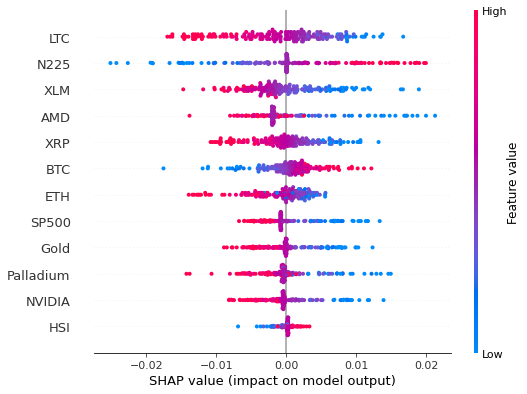

In [94]:
shap.initjs()
shap.summary_plot(shap_values_2D, x_test_2d)

The idea behind SHAP feature importance is simple: Features with large absolute Shapley values are important. Since we want the global importance, we average the absolute Shapley values per feature across the data:

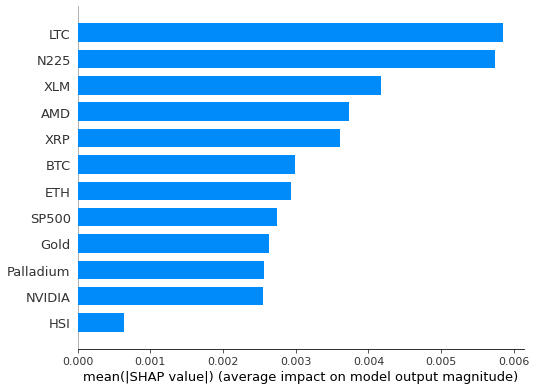

In [95]:
shap.initjs()
shap.summary_plot(shap_values_2D, x_test_2d, plot_type="bar")

SHAP feature importance is an alternative to permutation feature importance. There is a big difference between both importance measures: Permutation feature importance is based on the decrease in model performance. SHAP is based on magnitude of feature attributions.

The feature importance plot is useful, but contains no information beyond the importances. For a more informative plot, we will next look at the summary plot.

In [96]:
explainer